# Example calculating an effective Hamiltonian

This notebook demonstrates how to calculate an effective Hamiltonian with the `pairinteraction.perturbative` module.
We use https://arxiv.org/pdf/2410.21424 as a reference and try to reproduce figure 2c) and d) from the paper.
Note that the paper used a Schrieffer-Wolff transformation to calculate the effective Hamiltonian, while here we use perturbation theory up to third order.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np

import pairinteraction.real as pi
from pairinteraction import perturbative

logging.basicConfig(level=logging.ERROR)

In [2]:
if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

In [3]:
kets = {
    "+": pi.KetAtom("Rb", n=81, l=0, j=0.5, m=0.5),
    "0": pi.KetAtom("Rb", n=80, l=1, j=1.5, m=1.5),
    "-": pi.KetAtom("Rb", n=80, l=0, j=0.5, m=0.5),
}
pair_energy = kets["0"].get_energy("GHz") * 2

basis = pi.BasisAtom(
    species="Rb",
    n=(78, 83),
    l=(0, 2),
    j=(0.5, 4.5),
)

system = pi.SystemAtom(basis=basis)
system.enable_diamagnetism(True)
system.set_magnetic_field([0, 0, 60.7], "gauss")
system.diagonalize()

delta_energy = 5  # GHZ
basis_pair = pi.BasisPair(
    [system, system], energy=(pair_energy - delta_energy, pair_energy + delta_energy), energy_unit="GHz"
)
system_pair = pi.SystemPair(basis_pair)
system_pair.set_order(3)

SystemPairReal(BasisPairReal(|Rb:78,S_1/2,-1/2; Rb:83,S_1/2,-1/2⟩ ... |Rb:83,P_3/2,3/2; Rb:78,S_1/2,1/2⟩), is_diagonal=True)

In [4]:
theta_list = np.linspace(0, 90, 20)  # degree
R_list = np.linspace(8, 14, 20)  # mum

theta_default = 35.1  # rad
R_default = 11.6  # mum

order = 3

In [5]:
kets_list = [(kets["+"], kets["-"]), (kets["0"], kets["0"]), (kets["-"], kets["+"])]
H_eff = {"theta": [], "R": []}

for theta in theta_list:
    system_pair.set_distance_vector(
        R_default * np.array([np.sin(theta * np.pi / 180), 0, np.cos(theta * np.pi / 180)]), "micrometer"
    )
    h_eff, _ = perturbative.get_effective_hamiltonian_from_system(kets_list, system_pair, order, unit="MHz")
    H_eff["theta"].append(h_eff)

for R in R_list:
    system_pair.set_distance_vector(
        R * np.array([np.sin(theta_default * np.pi / 180), 0, np.cos(theta_default * np.pi / 180)]), "micrometer"
    )
    h_eff, _ = perturbative.get_effective_hamiltonian_from_system(kets_list, system_pair, order, unit="MHz")
    H_eff["R"].append(h_eff)

In [6]:
pair_energy = kets["+"].get_energy("GHz") + kets["0"].get_energy("GHz")
basis_pair = pi.BasisPair(
    [system, system], energy=(pair_energy - delta_energy, pair_energy + delta_energy), energy_unit="GHz"
)
system_pair = pi.SystemPair(basis_pair)
system_pair.set_order(3)

kets_list = [(kets["+"], kets["0"]), (kets["0"], kets["+"])]
H_eff_p0 = {"theta": [], "R": []}

for theta in theta_list:
    system_pair.set_distance_vector(
        R_default * np.array([np.sin(theta * np.pi / 180), 0, np.cos(theta * np.pi / 180)]), "micrometer"
    )
    h_eff, _ = perturbative.get_effective_hamiltonian_from_system(kets_list, system_pair, order, unit="MHz")
    H_eff_p0["theta"].append(h_eff)

for R in R_list:
    system_pair.set_distance_vector(
        R * np.array([np.sin(theta_default * np.pi / 180), 0, np.cos(theta_default * np.pi / 180)]), "micrometer"
    )
    h_eff, _ = perturbative.get_effective_hamiltonian_from_system(kets_list, system_pair, order, unit="MHz")
    H_eff_p0["R"].append(h_eff)

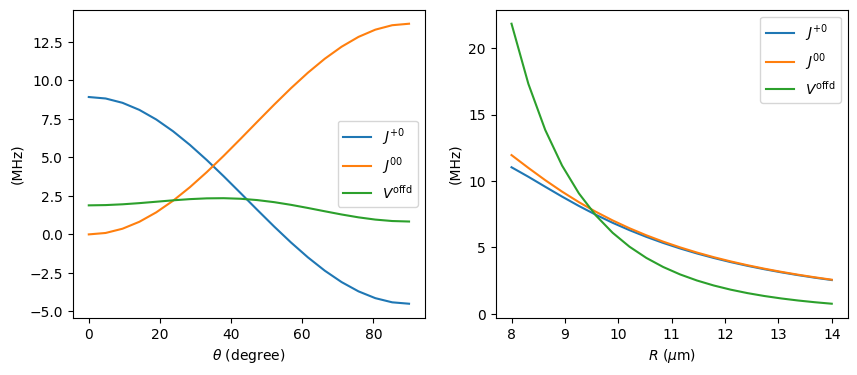

In [7]:
H_eff = {key: np.array(value) for key, value in H_eff.items()}
H_eff_p0 = {key: np.array(value) for key, value in H_eff_p0.items()}

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(theta_list, H_eff_p0["theta"][:, 0, 1], "C0-", label=r"$J^{+0}$")
axs[0].plot(theta_list, H_eff["theta"][:, 0, 1], "C1-", label=r"$J^{00}$")
axs[0].plot(theta_list, H_eff["theta"][:, 0, 2], "C2-", label=r"$V^\text{offd}$")
axs[0].set_xlabel(r"$\theta$ (degree)")

axs[1].plot(R_list, H_eff_p0["R"][:, 0, 1], "C0-", label=r"$J^{+0}$")
axs[1].plot(R_list, H_eff["R"][:, 0, 1], "C1-", label=r"$J^{00}$")
axs[1].plot(R_list, H_eff["R"][:, 0, 2], "C2-", label=r"$V^\text{offd}$")
axs[1].set_xlabel(r"$R$ ($\mu$m)")

for ax in axs:
    ax.legend()
    ax.set_ylabel(r"(MHz)")

plt.show()